In [1]:
% load centerline data and perform Jacobian calculation
clear;
close all;

G_solution = 4215; % INPUT
heat_flux_source = 852*1000; % INPUT [W/m2]
T_inlet_uniform = 300; % [K]

## load data for 3d temperature profile

In [2]:
digit_thousands = floor(G_solution/1000);
digit_hundreds = floor((G_solution - digit_thousands*1000)/100);
digit_tens= floor((G_solution - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname1      = ['./divisions_A_matrix/divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname1,'A_div_L_qbcs1');

% calculate 3d temperature profile
T_steady = A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;

## number grid

In [3]:
N_x_1 = 300+1; % INPUT total number of liquid grid points (including both ends) in x-direction
N_z = 100+1; % INPUT number of grid points (including both ends: inlet and outlet) in z-direction
N_x_2 = 40+1; % INPUT for solid substrate (including both ends: interface and outer wall)
N_x_tot = N_x_1 + N_x_2 - 1;
N_y = 19; % INPUT number of grid points in width direction

## INPUT sensor index (size: number sensor\*3)

In [4]:
% sensor_user_input = zeros(N_z-1,3); sensor_user_input(:,1) = 2:N_z; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all grid
% sensor_user_input = zeros(N_z-38,3); sensor_user_input(:,1) = 19:N_z-20; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all exp
sensor_user_input = [44,N_x_1,1; 72,N_x_1,1]; % 2 sensors

## Phi: sensor index within the grid

In [5]:
sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
number_sensor = length(sensor_index_z);
sensor_index = sensor_index_z + (sensor_index_x-1)*N_z + (sensor_index_y-1)*N_z*N_x_tot; %

Phi_location_sensor = sparse(number_sensor, N_x_tot*N_z*N_y); % within
Phi_location_sensor_z = zeros(number_sensor, N_z);
for ids=1:size(sensor_index, 1)
    Phi_location_sensor(ids, sensor_index(ids)) = 1;
    Phi_location_sensor_z(ids, sensor_index_z(ids)) = 1;
end

## generate artificial noise

In [6]:
rng('default')
T_sigma = 0.1; % INPUT [K] noise magnitude
M_samples = 300; % INPUT different case of noise
T_sensing_samples = zeros(number_sensor, M_samples); % [K] column matrix
T_sensing_samples = repmat(T_steady(sensor_index),1,M_samples) + normrnd(0, T_sigma, [number_sensor, M_samples]);

## to save result

In [7]:
G_samples = zeros(M_samples, 1); % store result
heat_flux_scalar_samples = zeros(M_samples, 1);
T_centerline_samples = zeros(N_z, M_samples);

## generate samples of result

In [8]:
for m=1:M_samples
    fprintf('samples %d / %d \n', m, M_samples);

samples 1 / 300 
samples 2 / 300 
samples 3 / 300 
samples 4 / 300 
samples 5 / 300 
samples 6 / 300 
samples 7 / 300 
samples 8 / 300 
samples 9 / 300 
samples 10 / 300 
samples 11 / 300 
samples 12 / 300 
samples 13 / 300 
samples 14 / 300 
samples 15 / 300 
samples 16 / 300 
samples 17 / 300 
samples 18 / 300 
samples 19 / 300 
samples 20 / 300 
samples 21 / 300 
samples 22 / 300 
samples 23 / 300 
samples 24 / 300 
samples 25 / 300 
samples 26 / 300 
samples 27 / 300 
samples 28 / 300 
samples 29 / 300 
samples 30 / 300 
samples 31 / 300 
samples 32 / 300 
samples 33 / 300 
samples 34 / 300 
samples 35 / 300 
samples 36 / 300 
samples 37 / 300 
samples 38 / 300 
samples 39 / 300 
samples 40 / 300 
samples 41 / 300 
samples 42 / 300 
samples 43 / 300 
samples 44 / 300 
samples 45 / 300 
samples 46 / 300 
samples 47 / 300 
samples 48 / 300 
samples 49 / 300 
samples 50 / 300 
samples 51 / 300 
samples 52 / 300 
samples 53 / 300 
samples 54 / 300 
samples 55 / 300 
samples 56 / 300 
s

## Make guess on G and heat source strength

In [9]:
    G_guess = G_solution; % [kg/m2/s]
    heat_flux_scalar_guess = heat_flux_source; % [W/m2]
    G_next = G_guess; % initialization
    heat_flux_scalar_next = heat_flux_scalar_guess; % initialization
    a_step = 0.5; % (hyperparameter) step size for stability

    n_iteration = 30;
    Jacobian_save = zeros(length(sensor_index), 2, n_iteration); % meas, parm, iter
    a_vector_save = zeros(length(sensor_index), n_iteration);
    G_guess_save = zeros(n_iteration); % history
    heat_flux_scalar_guess_save = zeros(n_iteration);

    % fprintf('original sol.: Q=%.3e, G=%.3e\n', heat_flux_source, G_solution);
    % fprintf('initial guess: Q=%.3e, G=%.3e, step size=%d\n', heat_flux_scalar_guess, G_guess, a_step);

for itr=1:n_iteration
    G_guess_save(itr) = G_guess;
    heat_flux_scalar_guess_save(itr) = heat_flux_scalar_guess;

## load precomputed calculations

In [10]:
    G_guess_floor = floor(G_guess/10)*10;
    digit_thousands = floor(G_guess_floor/1000);
    digit_hundreds = floor((G_guess_floor - digit_thousands*1000)/100);
    digit_tens= floor((G_guess_floor - digit_thousands*1000 - digit_hundreds*100)/10);
    digit_ones= floor(G_guess_floor - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
    inputname3      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];

    load(inputname3,'centerline_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_Tbcs');
    f_10floor = [centerline_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_Tbcs];

    G_guess_ceil = ceil(G_guess/10)*10;
    digit_thousands = floor(G_guess_ceil/1000);
    digit_hundreds = floor((G_guess_ceil - digit_thousands*1000)/100);
    digit_tens= floor((G_guess_ceil - digit_thousands*1000 - digit_hundreds*100)/10);
    digit_ones= floor(G_guess_ceil - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
    inputname4      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];

    load(inputname4,'centerline_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_Tbcs');
    f_10ceil = [centerline_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_Tbcs];

    if G_guess == G_guess_floor % no interpolation
        centerline_A_div_L_qbcs1 = f_10floor(:,1);
        centerline_A_div_A_conv_A_div_L_qbcs1 = f_10floor(:,2);
        centerline_A_div_A_conv_A_div_L_Tbcs = f_10floor(:,3);
    else % interpolation
        f_interp = f_10floor + (f_10ceil-f_10floor)/(G_guess_ceil-G_guess_floor)*(G_guess-G_guess_floor);
        centerline_A_div_L_qbcs1 = f_interp(:,1);
        centerline_A_div_A_conv_A_div_L_qbcs1 = f_interp(:,2);
        centerline_A_div_A_conv_A_div_L_Tbcs = f_interp(:,3);
    end

## centerline temperature and sensing

In [11]:
    T_centerline_guess = centerline_A_div_L_qbcs1*heat_flux_scalar_guess + T_inlet_uniform;
    T_sensing_guess = zeros(number_sensor, 1); % [K] column matrix
    T_sensing_guess = T_centerline_guess(sensor_index_z);

## feature measurement

temperature difference between calculation and data


In [12]:
    a_vector = T_sensing_guess - T_sensing_samples(:,m);
    % change of parameters (from Q and G)
    b_vector1 = Phi_location_sensor_z*centerline_A_div_L_qbcs1;
    b_vector2 = -(7/8/G_guess)*Phi_location_sensor_z*(centerline_A_div_A_conv_A_div_L_qbcs1*heat_flux_scalar_guess + centerline_A_div_A_conv_A_div_L_Tbcs);

## Jacobian matrix and update parameter

In [13]:
    Jacobian = [b_vector1, b_vector2];
    Jacobian_save(:,:,itr) = Jacobian;
    a_vector_save(:,itr) = a_vector;

    p_guess = [heat_flux_scalar_guess; G_guess];
    p_next = p_guess - a_step*pinv(Jacobian)*(a_vector);

    heat_flux_scalar_next = p_next(1);
    G_next = p_next(2);

## for next iteration

In [14]:
    % fprintf('iteration #%d: Q=%.3e, G=%.3e\n', itr, heat_flux_scalar_next, G_next);

    if abs(G_next-G_guess) < 1 && abs(heat_flux_scalar_guess-heat_flux_scalar_next) < 100 % stopping criteria
     % fprintf('stopping criteria: G and Q converged.\n');
        break;
    else
        heat_flux_scalar_guess = heat_flux_scalar_next;
        G_guess = G_next;
    end
end
if itr == n_iteration
    % fprintf('stopping criteria: set number of iteration. \n');
end

## save result

In [15]:
T_centerline_samples(:,m) = T_centerline_guess;
G_samples(m) = G_guess;
heat_flux_scalar_samples(m) = heat_flux_scalar_guess;
end

## analytical calculations

In [16]:
G_solution_floor = floor(G_solution/10)*10;
digit_thousands = floor(G_solution_floor/1000);
digit_hundreds = floor((G_solution_floor - digit_thousands*1000)/100);
digit_tens= floor((G_solution_floor - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution_floor - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname3      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname3,'centerline_A_div_L_qbcs1');
centerline_A_div_L_qbcs1_10floor = centerline_A_div_L_qbcs1;
T_centerline_10floor = centerline_A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;
T_sensing_10floor = Phi_location_sensor_z*T_centerline_10floor;

G_solution_ceil = ceil(G_solution/10 + sqrt(eps))*10;
digit_thousands = floor(G_solution_ceil/1000);
digit_hundreds = floor((G_solution_ceil - digit_thousands*1000)/100);
digit_tens= floor((G_solution_ceil - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution_ceil - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname4      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname4,'centerline_A_div_L_qbcs1');
centerline_A_div_L_qbcs1_10ceil = centerline_A_div_L_qbcs1;
T_centerline_10ceil = centerline_A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;
T_sensing_10ceil = Phi_location_sensor_z*T_centerline_10ceil;

if G_solution == G_solution_floor % no interpolation
    centerline_A_div_L_qbcs1 = centerline_A_div_L_qbcs1_10floor;
else % interpolation
    centerline_A_div_L_qbcs1 = centerline_A_div_L_qbcs1_10floor + (centerline_A_div_L_qbcs1_10ceil-centerline_A_div_L_qbcs1_10floor)/(G_solution_ceil-G_solution_floor)*(G_solution-G_solution_floor);
end

## derivation of noise ellipse

In [17]:
b_vector1 = Phi_location_sensor_z*centerline_A_div_L_qbcs1;
b_vector2 = (T_sensing_10ceil - T_sensing_10floor)/10;

T_noise_sigma = 0.1; % INPUT
H = zeros(number_sensor, 2); % 2 is number of parameter

H(:,1) = b_vector1*1000; % first column for Q[kW]
H(:,2) = b_vector2; % second column for G
cov_estimate = T_noise_sigma^2*inv(H'*H); % covariance
% ellipse of confidence bound
confidence_interval = 0.95; % INPUT confidence interval
scale_ellipsoid = -2*log(1 - confidence_interval); % equal to chi2inv(p, 2)
[eig_vector, eig_diag] = eig(cov_estimate * scale_ellipsoid); % eig_vector gives axis of ellipsoid
[eig_diag, order] = sort(diag(eig_diag), 'descend');
eig_diag = diag(eig_diag);
eig_vector = eig_vector(:, order);

plot_angles = linspace(0, 2*pi);
plot_ellipsoid = (eig_vector * sqrt(eig_diag)) * [cos(plot_angles(:))'; sin(plot_angles(:))'];

dQ_ellipsoid = plot_ellipsoid(1,1)*1000; % [W] max change
dG_ellipsoid = plot_ellipsoid(2,1); % max change

## pdf for G and Q

analytical pdf expression for G and Q


In [18]:
sigma_Q = sqrt(cov_estimate(1, 1));  % Standard deviation of Q [kW/m2]
sigma_G = sqrt(cov_estimate(2, 2));  % Standard deviation of G [kg/m2/s]

% Mean values of G and Q (you should already have these from your data)
mu_Q = heat_flux_source/1000;  % Mean of Q [kW/m2]
mu_G = G_solution;  % Mean of G

% Define the range for G and Q based on the sample data
x_Q = linspace(min(heat_flux_scalar_samples/1000), max(heat_flux_scalar_samples/1000), 100);  % 100 points for Q
x_G = linspace(min(G_samples), max(G_samples), 100);  % 100 points for G

% Compute the PDF of G and Q using the Gaussian formula
pdf_Q = (1 / sqrt(2 * pi * sigma_Q^2)) * exp(-(x_Q - mu_Q).^2 / (2 * sigma_Q^2));
pdf_G = (1 / sqrt(2 * pi * sigma_G^2)) * exp(-(x_G - mu_G).^2 / (2 * sigma_G^2));

## plot result


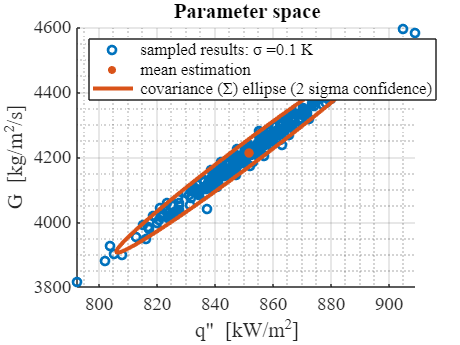

In [19]:
figure(1)
set(gcf, 'WindowState', 'maximized');
% subplot(2, 2, [1,3])
scatter(heat_flux_scalar_samples/1000, G_samples, 'o','Linewidth',2,'displayname', strcat(' sampled results: σ = ',num2str(T_sigma),' K'))
hold on
scatter(heat_flux_source/1000, G_solution, 50,'filled','displayname',' mean estimation')
hold on
plot(heat_flux_source/1000 + plot_ellipsoid(1, :), G_solution + plot_ellipsoid(2, :),'-', 'Linewidth', 3,'displayname',' covariance (Σ) ellipse (2 sigma confidence)','color','#D95319');
legend('show','location','northwest')
title('Parameter space')
ylabel('G [kg/m^2/s]')
xlabel('q" [kW/m^2]')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


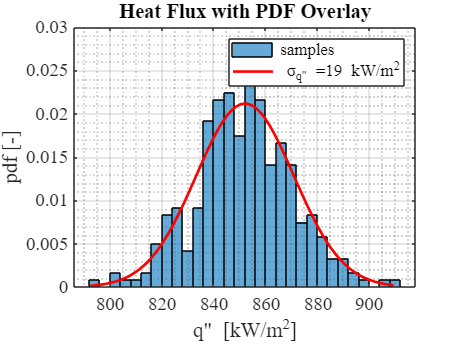

In [20]:

figure(2)
set(gcf, 'WindowState', 'maximized');
% Q (heat flux) histogram and PDF
% subplot(2, 2, 2);
histogram(heat_flux_scalar_samples/1000, 30, 'Normalization', 'pdf','displayname',' samples');
hold on
plot(x_Q, pdf_Q, 'r-', 'LineWidth', 2,'displayname', strcat(' σ_{q"} = ', num2str(sigma_Q, '%.0f'),' kW/m^2'));
legend('show','location','northeast')
xlabel('q" [kW/m^2]');
ylabel('pdf [-]');
title('Heat Flux with PDF Overlay');
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


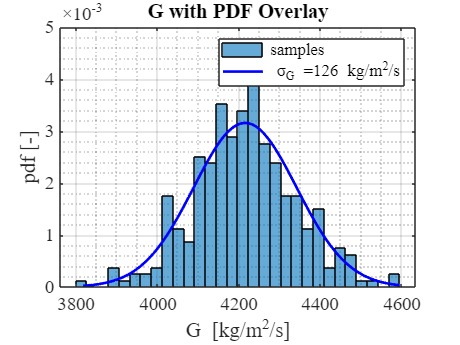

In [21]:

figure(3)
set(gcf, 'WindowState', 'maximized');
% G histogram and PDF
% subplot(2, 2, 4);
histogram(G_samples, 30, 'Normalization', 'pdf','displayname',' samples');
hold on
plot(x_G, pdf_G, 'b-', 'LineWidth', 2,'displayname', strcat(' σ_{G} = ', num2str(sigma_G, '%.0f'),' kg/m^2/s'));
legend('show','location','northeast')
xlabel('G [kg/m^2/s]');
ylabel('pdf [-]');
title('G with PDF Overlay');
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor